In [1]:
import os
import platform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

In [2]:
print(platform.system())
if platform.system() == 'Darwin':
    path = "/Volumes/Buffalo-SSD/Kaggle_Datasets/Kaggle_IEEE_FraudDetection/input/"
elif platform.system() == 'windows':
    path = "/Volumes/Buffalo-SSD/SIGNATE_Datasets/SIGNATE_TakedaAI/input/"

Darwin


In [3]:
os.listdir(path)

['test_transaction.csv',
 '._test_transaction.csv',
 'train_identity.csv',
 '._train_identity.csv',
 'test_identity.csv',
 '._test_identity.csv',
 'sample_submission.csv',
 '._sample_submission.csv',
 'train_transaction.csv',
 '._train_transaction.csv',
 'train_feature1.csv',
 'test_feature1.csv',
 'train_upsampled.csv',
 'val_data.csv',
 'train_downsampled.csv',
 'train_upsampled_all.csv',
 'train_downsampled_all.csv',
 'train_rus.csv',
 'train_ros.csv']

In [4]:
%%time
train = pd.read_csv(f'{path}train_feature1.csv')
#test = pd.read_csv(f'{path}test_feature1.csv')

CPU times: user 18.1 s, sys: 2.14 s, total: 20.2 s
Wall time: 22.3 s


Text(0.5, 1.0, 'Target variable count')

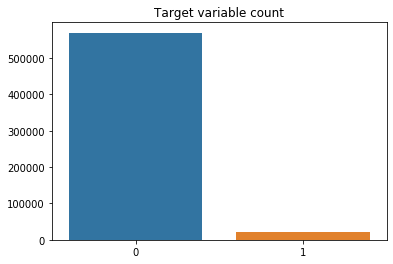

In [42]:
x=train['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

In [43]:
train[train['isFraud'] == 1]['isFraud'].shape[0] / train['isFraud'].shape[0]

0.03499000914417313

# trainとval

X_train,X_test,y_train,y_test=train_test_split(train.drop('isFraud',axis=1),train['isFraud'],test_size=.2,random_state=1)

del(train, test)

# over sampling

X=pd.concat([X_train,y_train],axis=1)

In [7]:
X = train

In [8]:
not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

In [9]:
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.isFraud.value_counts()

1    569877
0    569877
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

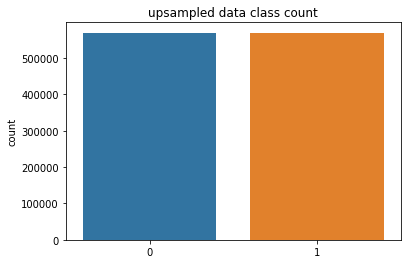

In [10]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')

In [11]:
upsampled.sort_values('TransactionDT').to_csv(f'{path}train_upsampled_all.csv')

pd.concat([X_test, y_test], axis=1).to_csv(f'{path}val_data.csv')

del(X, y, upsampled, fraud_upsampled)

In [12]:
del(upsampled, fraud_upsampled)

## Under Sampling

In [13]:
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

Text(0, 0.5, 'count')

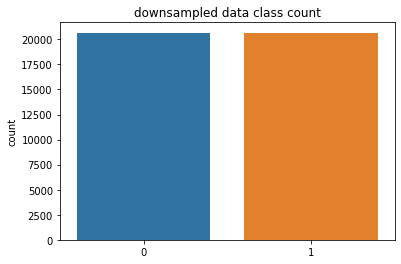

In [14]:
y=downsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('downsampled data class count')
plt.ylabel('count')

downsampled.sort_values('TransactionDT').to_csv(f'{path}train_downsampled.csv')

In [15]:
downsampled.sort_values('TransactionDT').to_csv(f'{path}train_downsampled_all.csv')

In [16]:
del(downsampled)

# imblearn

In [5]:
import imblearn

Using TensorFlow backend.


In [6]:
train.isnull().sum().sort_values(ascending=False).head()

D13      528588
D14      528353
D12      525823
id_03    524216
D6       517353
dtype: int64

## nanを-999で穴埋めした後に、nanに戻す

In [7]:
train2 = train.replace([np.inf, -np.inf], np.nan).fillna(-99999)

In [8]:
train2.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,2987000,0,86400,68.5,4,13926,-99999.0,150.0,1,142.0,...,267648,819269,446307,450258,517251,449555,6,6,6,6
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,267648,819269,446307,450258,517251,449555,4,0,6,6
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,824959,819269,446307,450258,517251,449555,5,0,6,6
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,824959,819269,446307,450258,517251,449555,9,0,6,6
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,267648,267353,19555,1061,544,134066,4,0,6,6


## under sampling

In [92]:
from imblearn.under_sampling import RandomUnderSampler

rus=RandomUnderSampler(return_indices=True) ##intialize to return indices of dropped rows
X_rus,y_rus,dropped = rus.fit_sample(train2.drop('isFraud', axis=1), train2['isFraud'])

In [97]:
df = pd.DataFrame(X_rus, columns = train.columns.drop('isFraud').to_list())
dfy = pd.DataFrame(y_rus, columns=['isFraud'])

In [99]:
rus_train = pd.concat([df, dfy], axis=1)

In [100]:
del(df, dfy, X_rus, y_rus, dropped, rus)

In [102]:
rus_train = rus_train.sort_values('TransactionDT')

In [103]:
rus_train = rus_train.replace({-99999:np.nan})

In [104]:
rus_train.to_csv(f'{path}train_rus.csv')

In [113]:
del(rus_train)

## over sampling

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros,y_ros= ros.fit_resample(train2.drop('isFraud', axis=1), train2['isFraud'])

In [10]:
df = pd.DataFrame(X_ros, columns = train.columns.drop('isFraud').to_list())
dfy = pd.DataFrame(y_ros, columns=['isFraud'])
ros_train = pd.concat([df, dfy], axis=1)

In [11]:
del(df, dfy, X_ros, y_ros, ros)

In [12]:
ros_train = ros_train.sort_values('TransactionDT')
ros_train = ros_train.replace({-99999:np.nan})
ros_train.to_csv(f'{path}train_ros.csv')

In [13]:
del(ros_train)

## Under-sampling: Tomek links

In [9]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(train2.drop('isFraud', axis=1), train2['isFraud'])

In [10]:
df = pd.DataFrame(X_tl, columns = train.columns.drop('isFraud').to_list())
dfy = pd.DataFrame(y_tl, columns=['isFraud'])
tl_train = pd.concat([df, dfy], axis=1)

del(df, dfy, X_tl, y_tl, id_tl)

In [11]:
tl_train = tl_train.sort_values('TransactionDT')
tl_train = tl_train.replace({-99999:np.nan})
tl_train.to_csv(f'{path}train_tl.csv')

In [12]:
del(tl_train)

## Over-sampling: SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(train2.drop('isFraud', axis=1), train2['isFraud'])

In [ ]:
df = pd.DataFrame(X_sm, columns = train.columns.drop('isFraud').to_list())
dfy = pd.DataFrame(y_sm, columns=['isFraud'])
sm_train = pd.concat([df, dfy], axis=1)

del(df, dfy, X_sm, y_sm)

In [ ]:
sm_train = sm_train.sort_values('TransactionDT')
sm_train = tl_train.replace({-99999:np.nan})
sm_train.to_csv(f'{path}train_sm.csv')

In [ ]:
del(sm_train)